##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [28]:
#%pip install pandas 
#%pip install matplotlib
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME 

## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .parquet file inside that. A relative path *must* be used when loading data into pandas

In [29]:
# Can have as many cells as you want for code
import pandas as pd
import numpy as np
filepath = "/Users/lilingyan/Desktop/Datathon/catB_train.parquet" 
#filepath = "./data/catB_train.parquet" 
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file

### **ALL** Code for machine learning and dataset analysis should be entered below. 
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

In [30]:
df = pd.read_parquet(filepath)

In [31]:
df.head()

,clntnum,race_desc,ctrycode_desc,clttype,stat_flag,min_occ_date,cltdob_fix,cltsex_fix,flg_substandard,flg_is_borderline_standard,...,recency_giclaim,giclaim_cnt_success,recency_giclaim_success,giclaim_cnt_unsuccess,recency_giclaim_unsuccess,flg_gi_claim_29d435_ever,flg_gi_claim_058815_ever,flg_gi_claim_42e115_ever,flg_gi_claim_856320_ever,f_purchase_lh
19550,91b546e924,Chinese,Singapore,P,ACTIVE,2017-10-31,1974-05-09,Female,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN
4600,896bae548c,Chinese,Singapore,P,ACTIVE,2007-05-23,1979-11-11,Male,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN
13337,f364439ae6,Others,Singapore,P,ACTIVE,2019-08-31,1976-01-28,Male,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN
15074,70f319cfe1,Chinese,Singapore,P,ACTIVE,2021-10-18,1976-03-19,Female,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN
19724,2647a81328,Chinese,Singapore,P,ACTIVE,2018-07-20,1995-07-31,Female,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN


SECTION 1: DATA ANALYSIS 
--- 
Data preprocessing: 

We are processing our columns according to 4 segments: 

#### General information
-  ['race_desc','ctrycode_desc','clttype','stat_flag','cltsex_fix','age','years_with_company']


#### User loyalty 
- avg_cancel_rate
- consent_level

#### Recovery 
- Risk level, 
- flg_latest_being_lapse, 
- n_months_last_bought_products, 
- recency_lapse, 
- recency_cancell 
- flg_is_proposal, 
- flg_with_preauthorisation, 
- flg_is_returned_mail, 
- is_dependent_in_at_least_one_policy
- aggregated product columns 

#### Monetary
- Income:  Annual_income_encoded
- Living status: flg_is_rental_flat 
- Household: hh_size_est_encoded
- Unemployment status: is_housewise_retiree
- Identity: is_sg_pr and is_class_1_2


#### target column: 
- f_purchase_lh




## General Information

- Almost all columns have None 
- meaning of P,G,C for customer type -> personal, group and corporate? This could be correlated to e.g. household information, possibly if they purchase as a family

In [32]:
def clean_general_info(df):
    df1 = df.copy()

    # races: None in race_desc should be replaced as a value. Either unknown or others 
    df1['race_desc'] = df1['race_desc'].fillna("Others")

    # country: None should be replaced with Not Applicable 
    # Combine both Not applicable and unknown country code 
    df1['ctrycode_desc'] = df1['ctrycode_desc'].fillna("Not Applicable")
    df1['ctrycode_desc'] = df1['ctrycode_desc'].apply(lambda x: "Not Application" if x == "Unknown Country Code" else x)

    # min_occ_date: calculate the duration this customer has been with singlife 
    # convert to datetime 
    df1['min_occ_date'] = pd.to_datetime(df1['min_occ_date'], errors='coerce')
    years_with_singlife = (pd.to_datetime('now') - df1['min_occ_date']).dt.days / 365.25
    median_duration = years_with_singlife.median() # pick median instead of mean? need to discuss
    df1['years_with_company'] = years_with_singlife.fillna(median_duration).astype(int)
    df1.drop('min_occ_date', axis=1, inplace=True)


    # cltdob_fix: calculate age
    df1['cltdob_fix'] = pd.to_datetime(df1['cltdob_fix'], errors='coerce')
    age_in_years = (pd.to_datetime('now') - df1['cltdob_fix']).dt.days / 365.25
    mean_age = age_in_years.mean()
    df1['age'] = age_in_years.fillna(mean_age).astype(int)
    # dropping DOB column 
    df1.drop('cltdob_fix', axis=1, inplace=True)

    # None value in gender 
    df1['cltsex_fix'].unique()
    # None value in gender: only a few, so replace by default: male 
    df1['cltsex_fix'] = df1['cltsex_fix'].fillna('Male')

    return df1 



In [33]:
df1 = clean_general_info(df)
df1.head().style

/var/folders/74/m6y7v_2j0p53ss3v0zp9rtbc0000gn/T/ipykernel_57675/1922872078.py:15: FutureWarning: The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()
  years_with_singlife = (pd.to_datetime('now') - df1['min_occ_date']).dt.days / 365.25
/var/folders/74/m6y7v_2j0p53ss3v0zp9rtbc0000gn/T/ipykernel_57675/1922872078.py:23: FutureWarning: The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()
  age_in_years = (pd.to_datetime('now') - df1['cltdob_fix']).dt.days / 365.25


,clntnum,race_desc,ctrycode_desc,clttype,stat_flag,cltsex_fix,flg_substandard,flg_is_borderline_standard,flg_is_revised_term,flg_is_rental_flat,flg_has_health_claim,flg_has_life_claim,flg_gi_claim,flg_is_proposal,flg_with_preauthorisation,flg_is_returned_mail,is_consent_to_mail,is_consent_to_email,is_consent_to_call,is_consent_to_sms,is_valid_dm,is_valid_email,is_housewife_retiree,is_sg_pr,is_class_1_2,is_dependent_in_at_least_1_policy,f_ever_declined_la,hh_20,pop_20,hh_size,hh_size_est,annual_income_est,n_months_last_bought_products,flg_latest_being_lapse,flg_latest_being_cancel,recency_lapse,recency_cancel,tot_inforce_pols,tot_cancel_pols,ape_gi_42e115,ape_ltc_1280bf,ape_grp_6fc3e6,ape_grp_de05ae,ape_inv_dcd836,ape_grp_945b5a,ape_grp_6a5788,ape_ltc_43b9d5,ape_grp_9cdedf,ape_lh_d0adeb,ape_grp_1581d7,ape_grp_22decf,ape_lh_507c37,ape_lh_839f8a,ape_inv_e9f316,ape_gi_a10d1b,ape_gi_29d435,ape_grp_caa6ff,ape_grp_fd3bfb,ape_lh_e22a6a,ape_grp_70e1dd,ape_grp_e04c3a,ape_grp_fe5fb8,ape_gi_856320,ape_grp_94baec,ape_gi_058815,ape_grp_e91421,ape_lh_f852af,ape_lh_947b15,ape_32c74c,sumins_gi_42e115,sumins_ltc_1280bf,sumins_grp_6fc3e6,sumins_grp_de05ae,sumins_inv_dcd836,sumins_grp_945b5a,sumins_grp_6a5788,sumins_ltc_43b9d5,sumins_grp_9cdedf,sumins_lh_d0adeb,sumins_grp_1581d7,sumins_grp_22decf,sumins_lh_507c37,sumins_inv_e9f316,sumins_gi_a10d1b,sumins_gi_29d435,sumins_grp_caa6ff,sumins_grp_fd3bfb,sumins_lh_e22a6a,sumins_grp_70e1dd,sumins_grp_e04c3a,sumins_grp_fe5fb8,sumins_gi_856320,sumins_grp_94baec,sumins_gi_058815,sumins_grp_e91421,sumins_lh_f852af,sumins_lh_947b15,sumins_32c74c,prempaid_gi_42e115,prempaid_ltc_1280bf,prempaid_grp_6fc3e6,prempaid_grp_de05ae,prempaid_inv_dcd836,prempaid_grp_945b5a,prempaid_grp_6a5788,prempaid_ltc_43b9d5,prempaid_grp_9cdedf,prempaid_lh_d0adeb,prempaid_grp_1581d7,prempaid_grp_22decf,prempaid_lh_507c37,prempaid_lh_839f8a,prempaid_inv_e9f316,prempaid_gi_a10d1b,prempaid_gi_29d435,prempaid_grp_caa6ff,prempaid_grp_fd3bfb,prempaid_lh_e22a6a,prempaid_grp_70e1dd,prempaid_grp_e04c3a,prempaid_grp_fe5fb8,prempaid_gi_856320,prempaid_grp_94baec,prempaid_gi_058815,prempaid_grp_e91421,prempaid_lh_f852af,prempaid_lh_947b15,prempaid_32c74c,ape_839f8a,ape_e22a6a,ape_d0adeb,ape_c4bda5,ape_ltc,ape_507c37,ape_gi,f_hold_839f8a,f_hold_e22a6a,f_hold_d0adeb,f_hold_c4bda5,f_hold_ltc,f_hold_507c37,f_hold_gi,sumins_839f8a,sumins_e22a6a,sumins_d0adeb,sumins_c4bda5,sumins_ltc,sumins_507c37,sumins_gi,prempaid_839f8a,prempaid_e22a6a,prempaid_d0adeb,prempaid_c4bda5,prempaid_ltc,prempaid_507c37,prempaid_gi,lapse_ape_ltc_1280bf,lapse_ape_grp_6fc3e6,lapse_ape_grp_de05ae,lapse_ape_inv_dcd836,lapse_ape_grp_945b5a,lapse_ape_grp_6a5788,lapse_ape_ltc_43b9d5,lapse_ape_grp_9cdedf,lapse_ape_lh_d0adeb,lapse_ape_grp_1581d7,lapse_ape_grp_22decf,lapse_ape_lh_507c37,lapse_ape_lh_839f8a,lapse_ape_inv_e9f316,lapse_ape_grp_caa6ff,lapse_ape_grp_fd3bfb,lapse_ape_lh_e22a6a,lapse_ape_grp_70e1dd,lapse_ape_grp_e04c3a,lapse_ape_grp_fe5fb8,lapse_ape_grp_94baec,lapse_ape_grp_e91421,lapse_ape_lh_f852af,lapse_ape_lh_947b15,lapse_ape_32c74c,n_months_since_lapse_ltc_1280bf,n_months_since_lapse_grp_6fc3e6,n_months_since_lapse_grp_de05ae,n_months_since_lapse_inv_dcd836,n_months_since_lapse_grp_945b5a,n_months_since_lapse_grp_6a5788,n_months_since_lapse_ltc_43b9d5,n_months_since_lapse_grp_9cdedf,n_months_since_lapse_lh_d0adeb,n_months_since_lapse_grp_1581d7,n_months_since_lapse_grp_22decf,n_months_since_lapse_lh_507c37,n_months_since_lapse_lh_839f8a,n_months_since_lapse_inv_e9f316,n_months_since_lapse_grp_caa6ff,n_months_since_lapse_grp_fd3bfb,n_months_since_lapse_lh_e22a6a,n_months_since_lapse_grp_70e1dd,n_months_since_lapse_grp_e04c3a,n_months_since_lapse_grp_fe5fb8,n_months_since_lapse_grp_94baec,n_months_since_lapse_grp_e91421,n_months_since_lapse_lh_f852af,n_months_since_lapse_lh_947b15,n_months_since_lapse_32c74c,f_ever_bought_839f8a,f_ever_bought_e22a6a,f_ever_bought_d0adeb,f_ever_bought_c4bda5,f_ever_bought_ltc,f_ever_bought_507c37,f_ever_bought_gi,n_months_last_bought_

### Data visualisation for general information 


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
# process target column f_purcahse_lh as 0 and 1 
df1['f_purchase_lh'] = df1['f_purchase_lh'].fillna(0)

In [36]:
def plot_stacked_bars(dataframe, title_, ylabel_, size_=(18, 10), rot_=0, legend_="upper right"):
    """
    Plot stacked bars with annotations
    """
    ax = dataframe.plot(
        kind="bar",
        stacked=True,
        figsize=size_,
        rot=rot_,
        title=title_
    )

    # Annotate bars
    annotate_stacked_bars(ax, textsize=10)
    # Rename legend
    plt.legend(["Never Purchase", "Purchased"], loc=legend_)
    # Labels
    plt.ylabel(ylabel_)
    plt.show()

def annotate_stacked_bars(ax, pad=0.99, colour="black", textsize=13):
    """
    Add value annotations to the bars
    """

    # Iterate over the plotted rectanges/bars
    for p in ax.patches:
        
        # Calculate annotation
        value = str(round(p.get_height()))
        # If value is 0 do not annotate
        if value == '0':
            continue
        ax.annotate(
            value,
            ((p.get_x()+ p.get_width()/2)*pad-0.1, (p.get_y()+p.get_height()/2)*pad),
            color=colour,
            size=textsize
        )

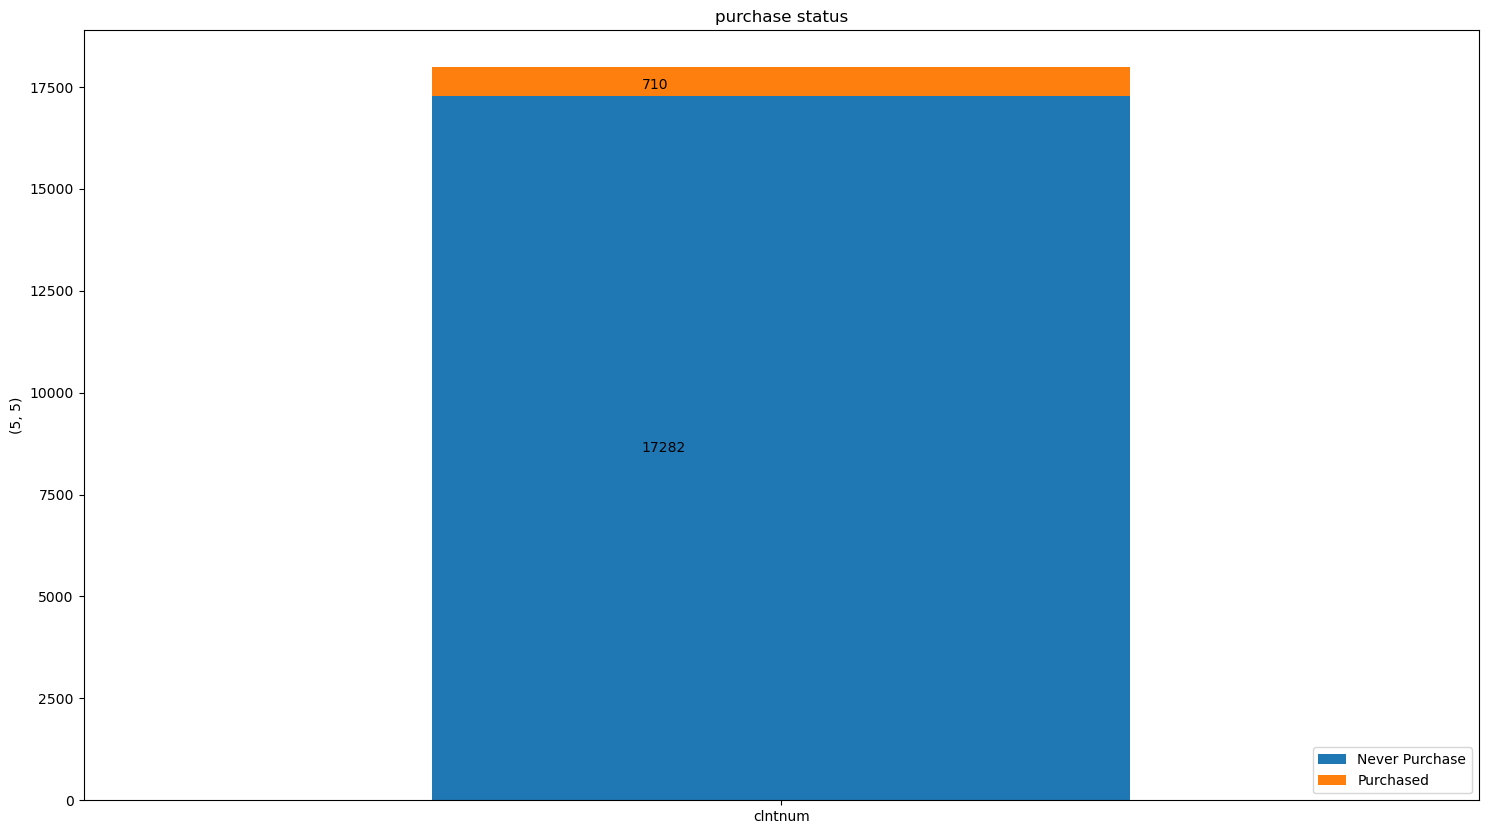

In [37]:
purchase = df1[['clntnum', 'f_purchase_lh']]
purchase_total = purchase.groupby(purchase['f_purchase_lh']).count()
purchase_percentage = purchase_total / purchase_total.sum() * 100
plot_stacked_bars(purchase_total.transpose(), "purchase status", (5, 5), legend_="lower right")

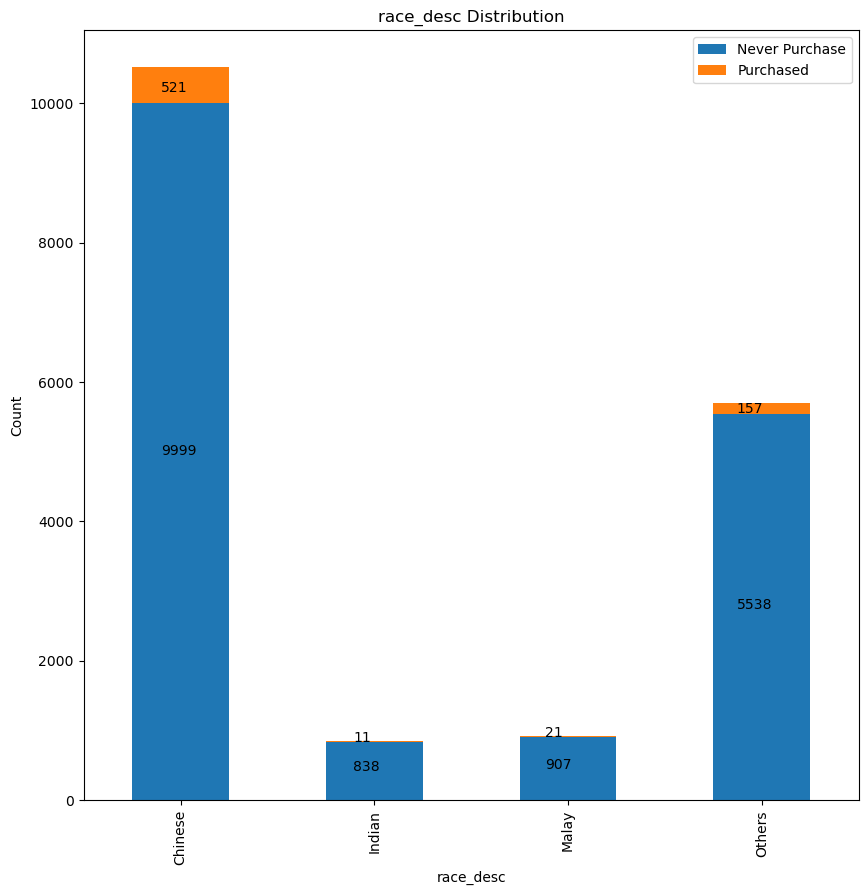

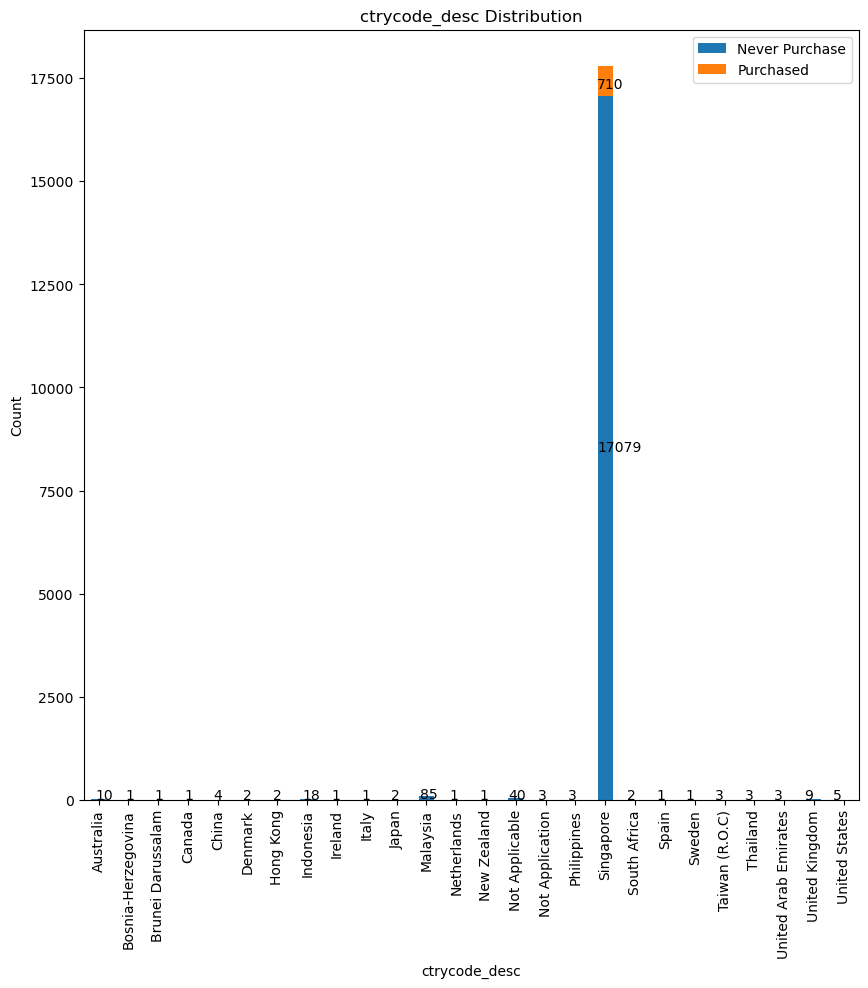

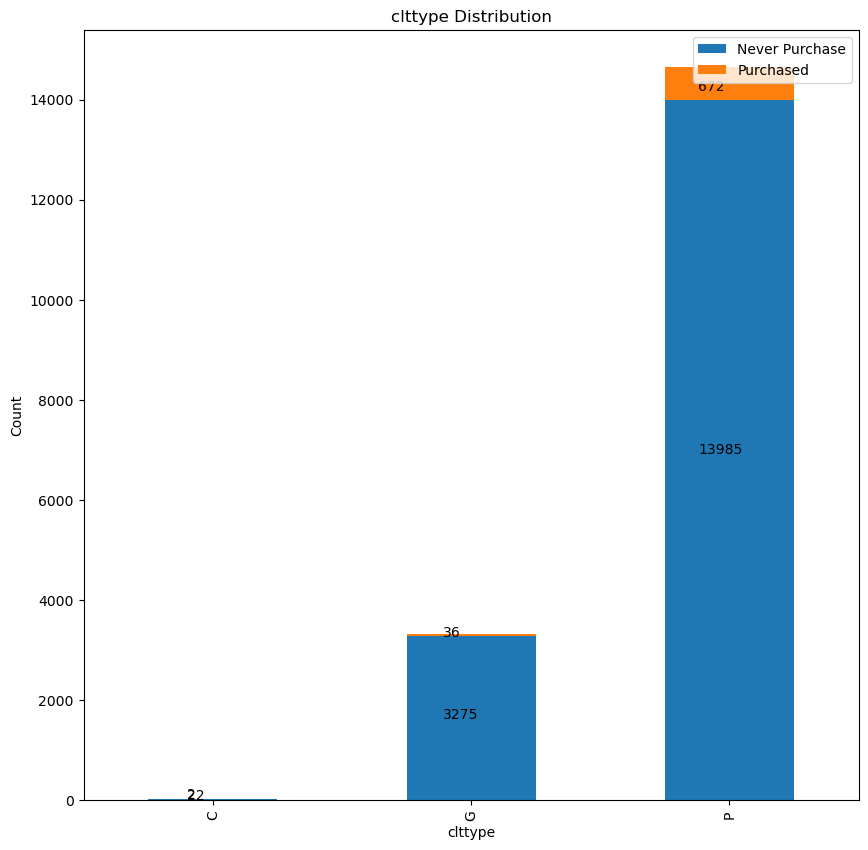

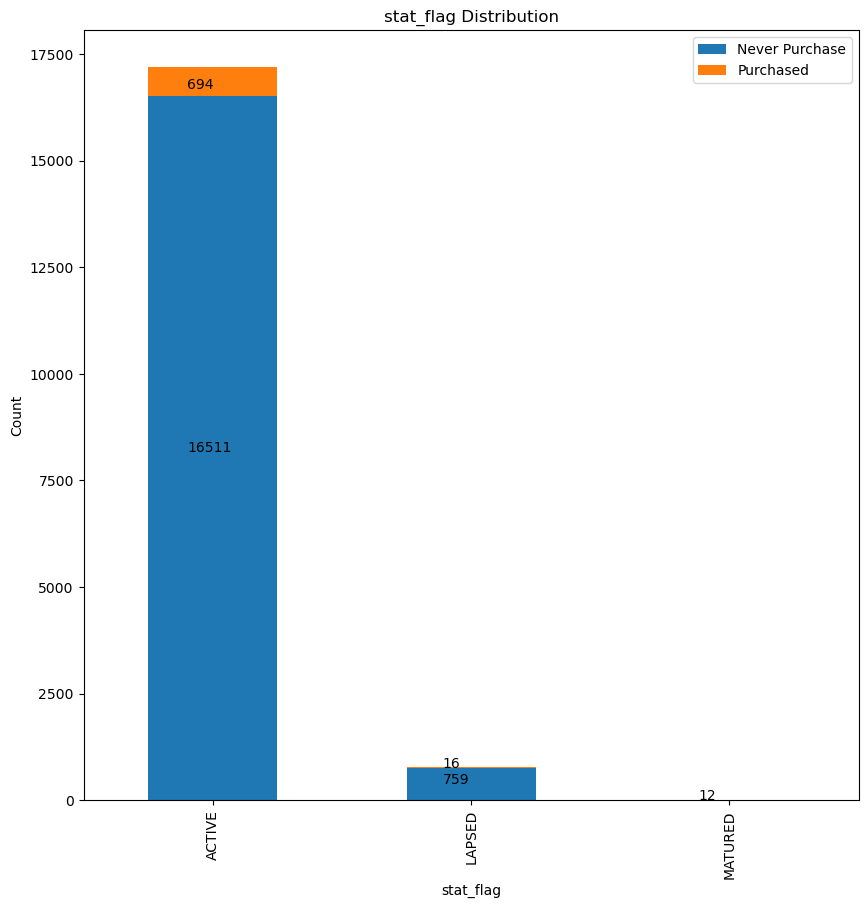

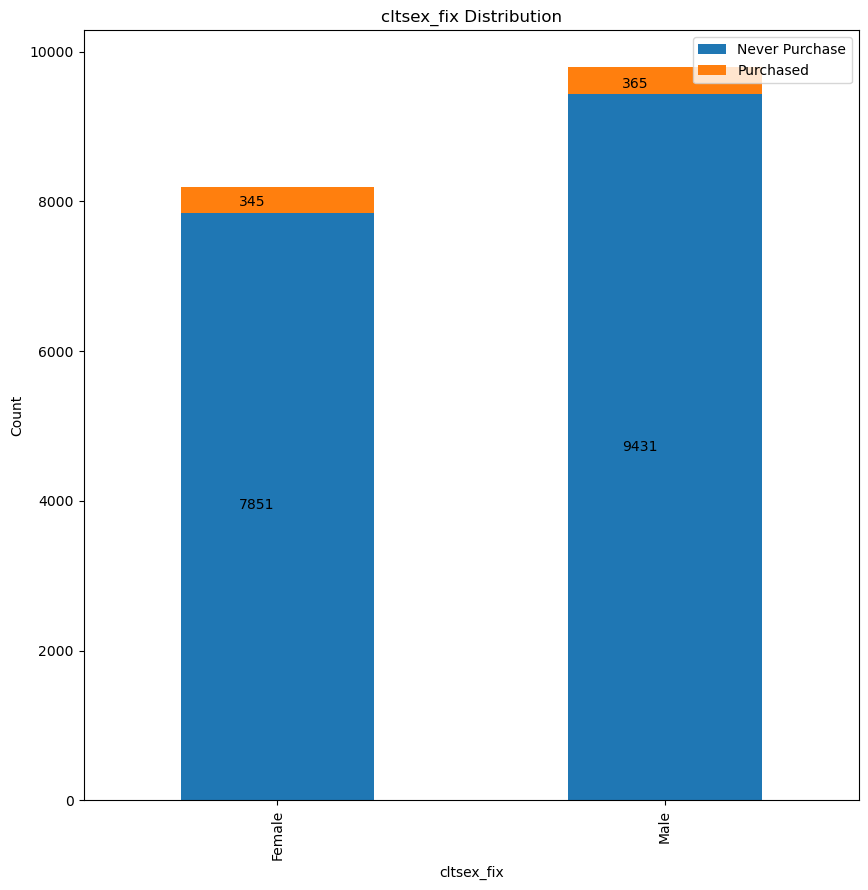

In [38]:
general_info_cat_col = ['race_desc','ctrycode_desc','clttype','stat_flag','cltsex_fix']
for col in general_info_cat_col:
    tb = pd.pivot_table(df1,index=col,values='clntnum', columns='f_purchase_lh',aggfunc='count',fill_value=0)
    plot_stacked_bars(tb, f"{col} Distribution", "Count",size_=(10, 10), rot_=90, legend_="upper right")

In [39]:
# def plot_distribution(dataframe, column, ax, bins_=50):
#     # Create a temporal dataframe with the data to be plot
#     temp = pd.DataFrame({"Never Purchased": dataframe[dataframe["f_purchase_lh"]==0][column],
#     "Purchased":dataframe[dataframe["f_purchase_lh"]==1][column]})
#     # Plot the histogram
#     temp[["Never Purchased","Purchased"]].plot(kind='hist', bins=bins_, ax=ax, stacked=True)
#     # X-axis label
#     ax.set_xlabel(column)
#     # Change the x-axis to plain style
#     ax.ticklabel_format(style='plain', axis='x')

In [40]:
# general_info_num_col = ["age","years_with_company"]
# for col in general_info_num_col:
#        fig, axs = plt.subplots(nrows=1, figsize=(10, 5))
#        plot_distribution(df1,col,axs)
#        axs.axvline(df1[col].mean(), color='red', linestyle='dashed', linewidth=2, label='Mean')

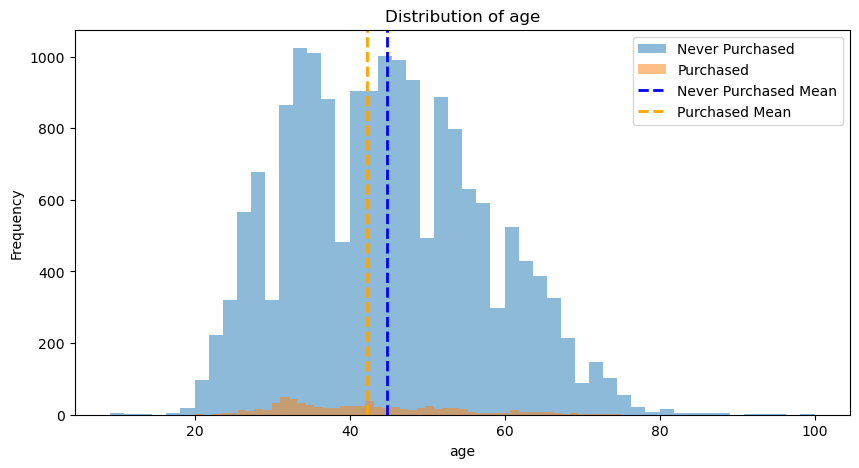

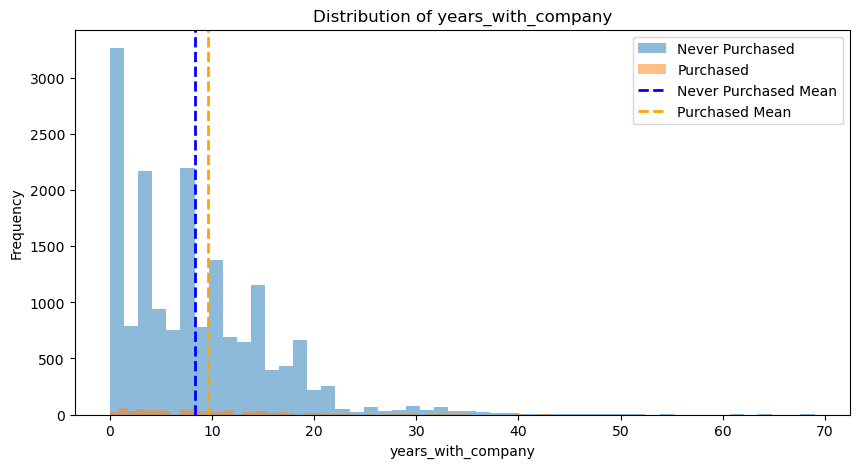

In [41]:
import matplotlib.pyplot as plt
import pandas as pd

general_info_num_col = ["age", "years_with_company"]

for col in general_info_num_col:
    fig, axs = plt.subplots(nrows=1, figsize=(10, 5))
    
    # Plot histogram
    df1[df1["f_purchase_lh"] == 0][col].plot(kind='hist', bins=50, ax=axs, alpha=0.5, label='Never Purchased')
    df1[df1["f_purchase_lh"] == 1][col].plot(kind='hist', bins=50, ax=axs, alpha=0.5, label='Purchased')
    
    #show the distribution mean for "Never Purchased"
    axs.axvline(df1[df1["f_purchase_lh"] == 0][col].mean(), color='blue', linestyle='dashed', linewidth=2, label='Never Purchased Mean')
    
    #show the distribution mean for "Purchased"
    axs.axvline(df1[df1["f_purchase_lh"] == 1][col].mean(), color='orange', linestyle='dashed', linewidth=2, label='Purchased Mean')
    
    axs.legend()

    axs.set_title(f'Distribution of {col}')
    axs.set_xlabel(col)
    axs.set_ylabel('Frequency')

plt.show()


Ovservation: 
1. Country code seem to be highly biased to Singapore, we will combine all other countries together and treat it as others 
2. Most people are with company for a few years, but we have outliers who are with outliers for more than 30 years. 
3. Age is follow normal distribution 

## Feature Engineering for general information 

In [42]:
df1['ctrycode_desc'] = df1['ctrycode_desc'].apply(lambda x: "Others" if x != "Singapore" else x)

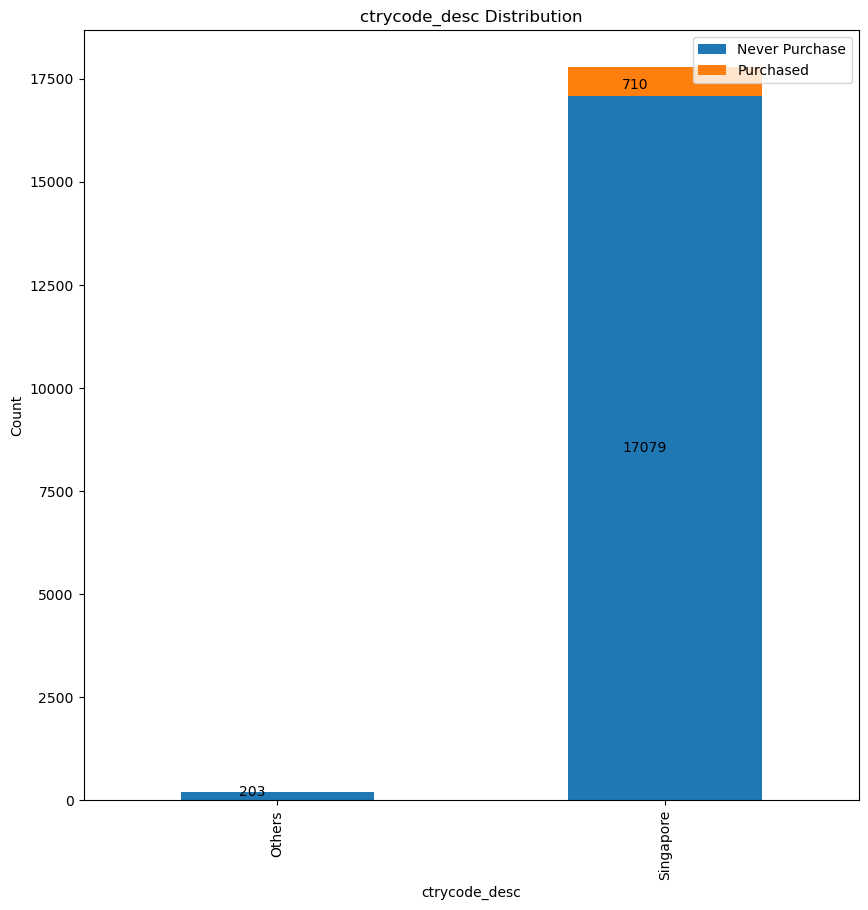

In [43]:
tb = pd.pivot_table(df1,index='ctrycode_desc',values='clntnum', columns='f_purchase_lh',aggfunc='count',fill_value=0)
plot_stacked_bars(tb, "ctrycode_desc Distribution", "Count",size_=(10, 10), rot_=90, legend_="upper right")

In [44]:
general_columns_to_keep = ['race_desc','ctrycode_desc','clttype','stat_flag','cltsex_fix','age','years_with_company']

## Client Risk and Status Indicators
1. flg_substandard: Flag for substandard risk clients : client with higher than avg risk of loss 
2. flg_is_borderline_standard: Flag for borderline standard risk clients : in between standard risk and substandard risk 
3. flg_is_revised_term: Flag if customer ever has revised terms: adjustment made to the policy
4. flg_is_rental_flat: Indicates if the client lives in a rental flat : coule be related to household / useful for economic status 
5. flg_has_health_claim: Flag for clients with health insurance claims.
6. flg_has_life_claim: Flag for clients with life insurance claims.
7. flg_gi_claim: Flag for general insurance claims.
8. flg_is_proposal: Indicates if there is a policy in proposal for client: having a policy under review -> this could be quite important, as if the client is currently considering some policies, the probablity of purcashing could be higher 
9. flg_with_preauthorisation: Flag for clients with preauthorized transactions or policies: e.g. client have given permission for certain types of transcation, e.g. premium payment, 
10. flg_is_returned_mail: Flag for returned mail instances: the mail given is unresponse 

Some thoughts: 
- A few features can indicate whether the customer is actively responding(e.g. whether they already have an insurance, returned mail etc.), their economic status and their risk. Feature engineering could be along these lines 


In [45]:
def clean_up_risk_and_status(df):
    df1 = df.copy()
    # clean up float to int 
    columns_to_convert = ['flg_substandard', 'flg_is_borderline_standard', 'flg_is_revised_term',
       'flg_is_rental_flat', 'flg_has_health_claim', 'flg_has_life_claim',
       'flg_gi_claim', 'flg_is_proposal', 'flg_with_preauthorisation',
       'flg_is_returned_mail']
    for column in columns_to_convert:
        df1[column] = df1[column].fillna(0).astype(float).astype(int)

    # New feature 1: has health / life / general insurance -> there is no need to distinguish them as the Qn ask for general purcahase too 

    # 1. Number of Insurance purchased
    df1['num_total_claims'] = (df1['flg_has_health_claim'] + df1['flg_has_life_claim'] + df1['flg_gi_claim']).fillna(0)

    # 2. whether they purchased insurance (bought at least once)
    df1['flg_health_or_life_claim'] = df1['flg_has_health_claim'] | df1['flg_has_life_claim'] | df1['flg_gi_claim']

    # 3. combine risk together: substandard risk -> level 3, boarderline -> level 2, standard -> level 1 
    conditions = [
        df1['flg_substandard'] == 1,
        df1['flg_is_borderline_standard'] == 1,
        ~(df1['flg_substandard'] == 1) & ~(df1['flg_is_borderline_standard'] == 1)  # Standard risk
    ]

    values = [3, 2, 1]

    # Create a new column 'risk_level' based on the conditions, if na means standard 
    df1['risk_level'] = np.select(conditions, values, default=1)

    # 4. dropping used columns 
    df1.drop(columns = ['flg_substandard','flg_is_borderline_standard','flg_has_health_claim','flg_has_life_claim','flg_gi_claim'],inplace=True)
    
    return df1


In [46]:
df2 = clean_up_risk_and_status(df1)
df2.head()

,clntnum,race_desc,ctrycode_desc,clttype,stat_flag,cltsex_fix,flg_is_revised_term,flg_is_rental_flat,flg_is_proposal,flg_with_preauthorisation,...,flg_gi_claim_29d435_ever,flg_gi_claim_058815_ever,flg_gi_claim_42e115_ever,flg_gi_claim_856320_ever,f_purchase_lh,years_with_company,age,num_total_claims,flg_health_or_life_claim,risk_level
19550,91b546e924,Chinese,Singapore,P,ACTIVE,Female,0,0,0,0,...,None,None,None,None,0.0,6,49,0,0,1
4600,896bae548c,Chinese,Singapore,P,ACTIVE,Male,0,0,0,0,...,None,None,None,None,0.0,16,44,0,0,1
13337,f364439ae6,Others,Singapore,P,ACTIVE,Male,0,0,0,0,...,None,None,None,None,0.0,4,48,0,0,1
15074,70f319cfe1,Chinese,Singapore,P,ACTIVE,Female,0,0,0,0,...,None,None,None,None,0.0,2,47,0,0,1
19724,2647a81328,Chinese,Singapore,P,ACTIVE,Female,0,0,0,0,...,None,None,None,None,0.0,5,28,0,0,1


In [47]:
risk_related_col = ['risk_level']
active_related_col = ['flg_is_proposal','num_total_claims','flg_health_or_life_claim','flg_with_preauthorisation','flg_is_returned_mail']


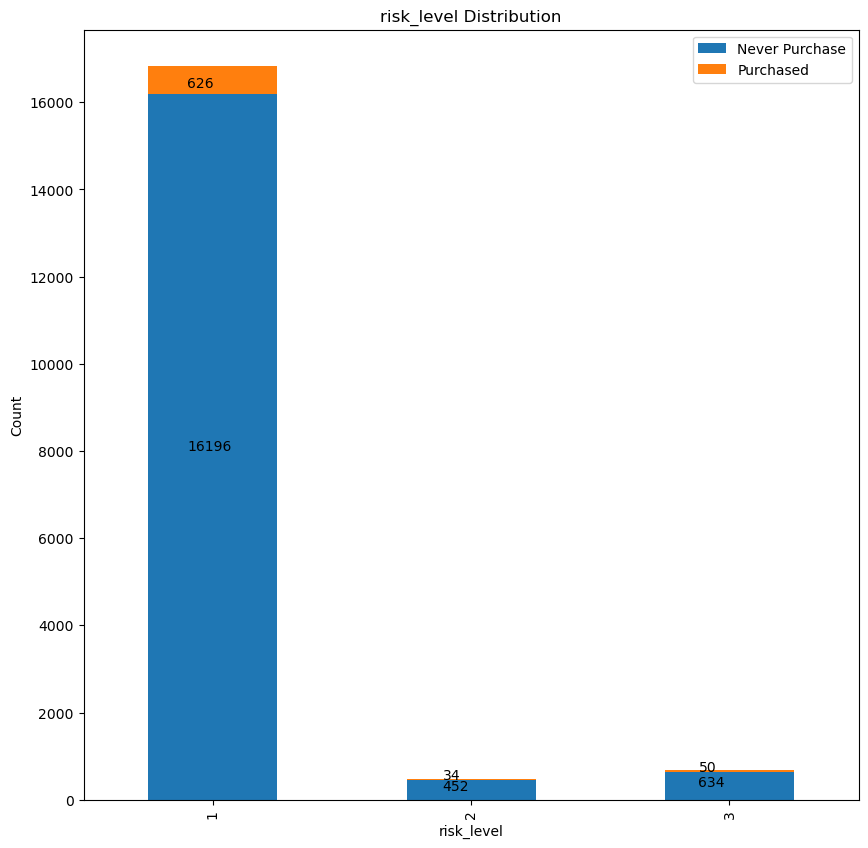

In [48]:
for col in risk_related_col:
    tb = pd.pivot_table(df2,index=col,values='clntnum', columns='f_purchase_lh',aggfunc='count',fill_value=0)
    plot_stacked_bars(tb, f"{col} Distribution", "Count",size_=(10, 10), rot_=90, legend_="upper right")

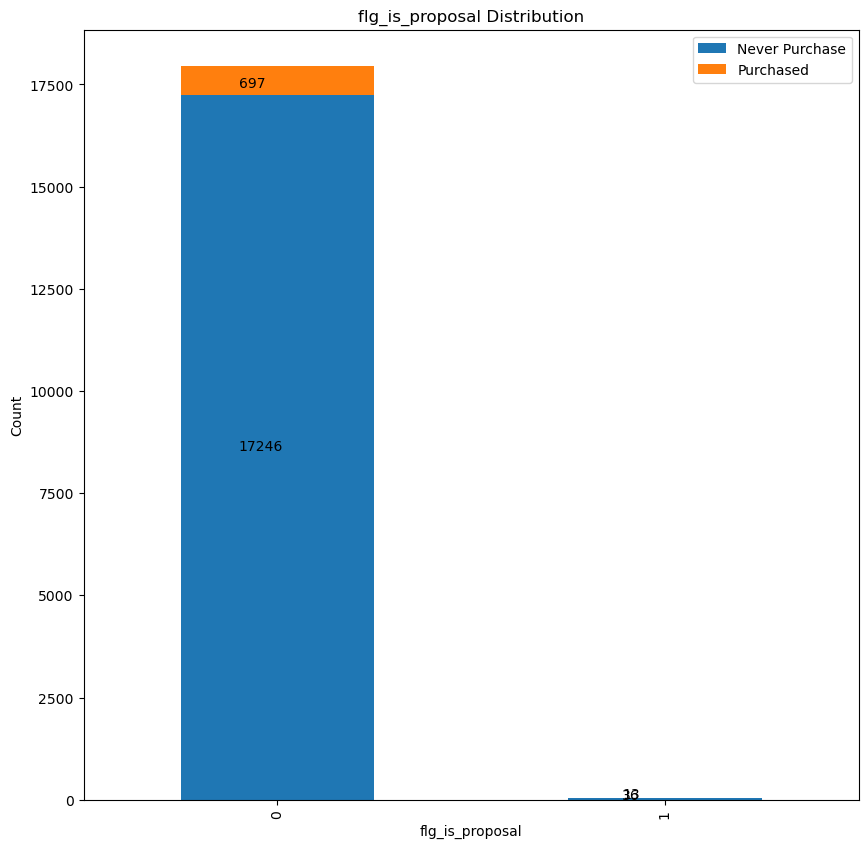

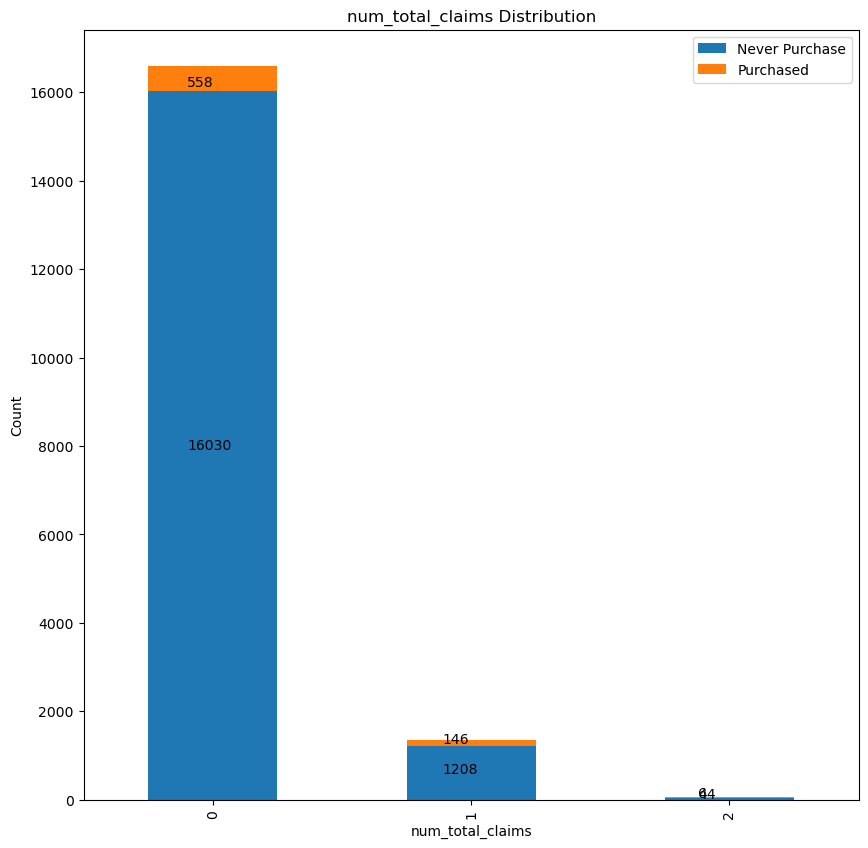

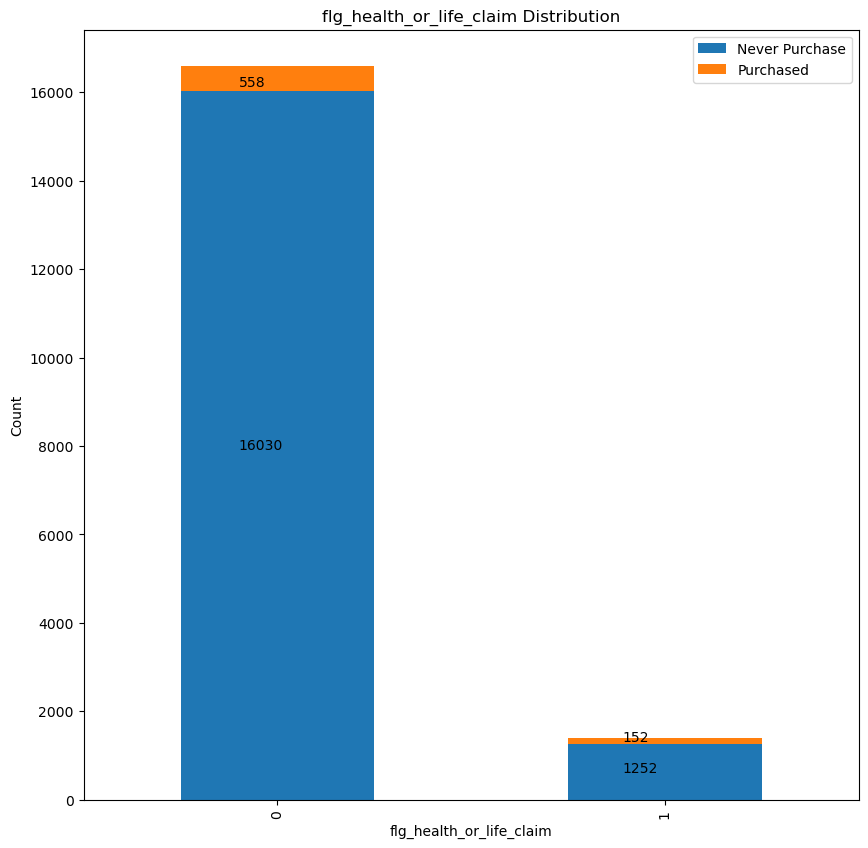

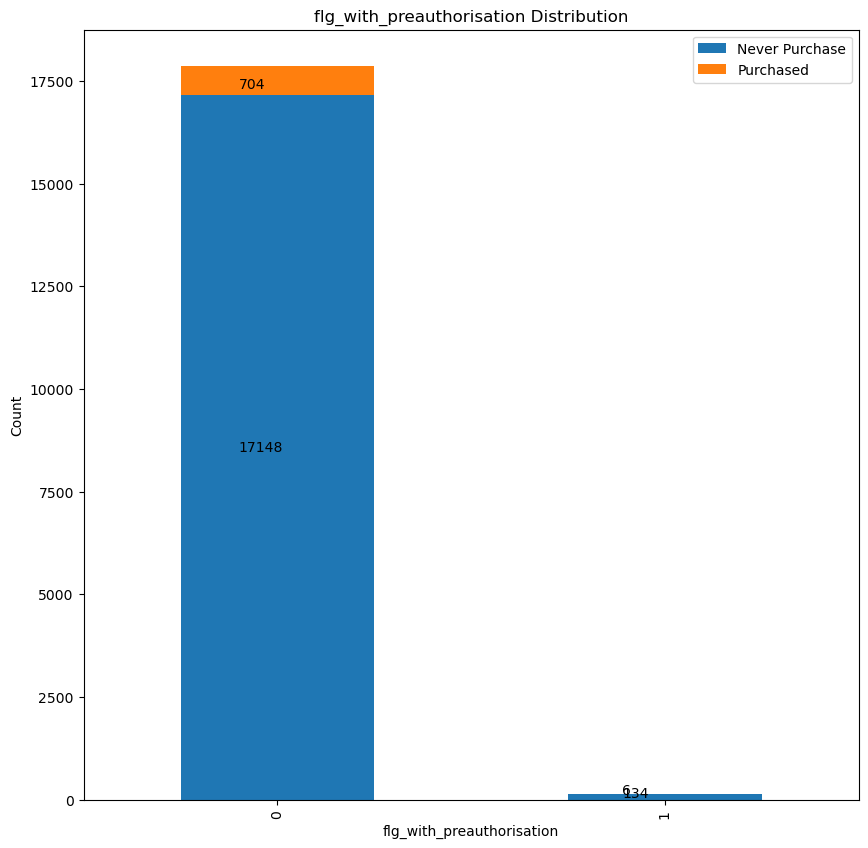

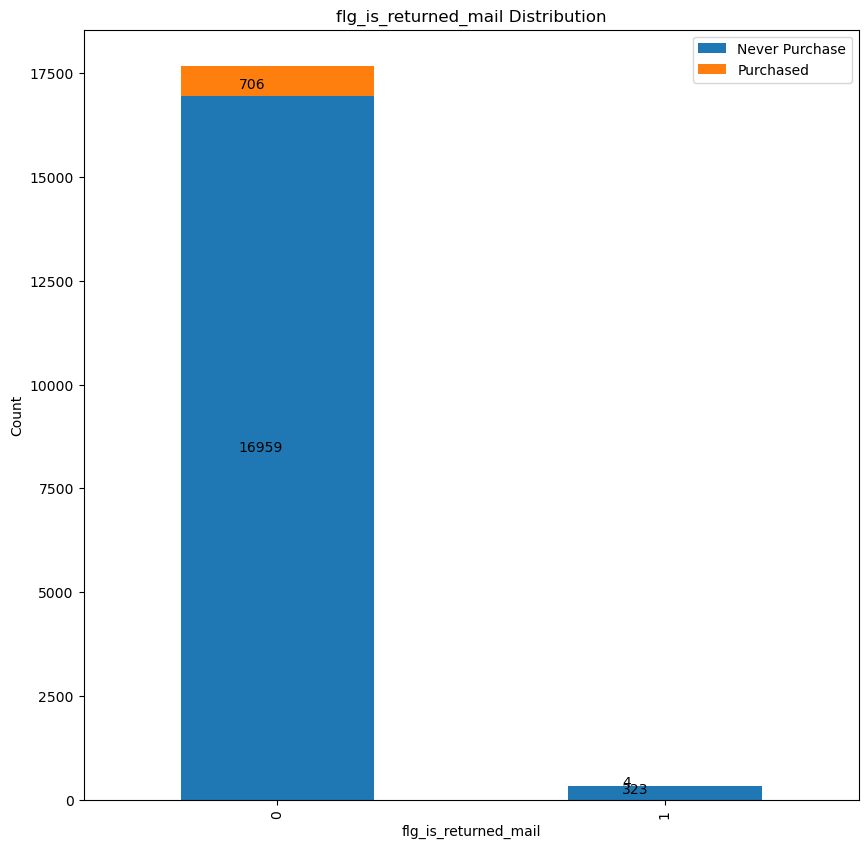

In [49]:
for col in active_related_col:
    tb = pd.pivot_table(df2,index=col,values='clntnum', columns='f_purchase_lh',aggfunc='count',fill_value=0)
    plot_stacked_bars(tb, f"{col} Distribution", "Count",size_=(10, 10), rot_=90, legend_="upper right")

## Demographic and Household Information
- pop_20 / hh_20 = hh_size 
- hh_size_set is a rounded value of hh_size 
- There is no need to keep all, and hh_size_est will be good enough 

In [50]:
df2['annual_income_est'].unique()

array(['C.60K-100K', 'D.30K-60K', 'A.ABOVE200K', 'B.100K-200K',
       'E.BELOW30K', None], dtype=object)

In [51]:
def clean_up_household_info(df):

    df1 = df.copy()

    household_col = ['is_housewife_retiree', 'is_sg_pr', 'is_class_1_2',
       'is_dependent_in_at_least_1_policy', 'hh_20',
       'pop_20']
       
    for column in household_col:
        df1[column] = df1[column].fillna(0).astype(float).astype(int)

    # annual income set 
    df1['annual_income_est'] = df1['annual_income_est'].fillna("F.UNKNOWN")
    income_mapping = {
        'F. UNKNOWN': 0,
        'E.BELOW30K': 1,
        'D.30K-60K': 2,
        'C.60K-100K': 3,
        'B.100K-200K': 4,
        'A.ABOVE200K': 5
    }

    # Apply ordinal encoding
    df1['annual_income_encoded'] = df1['annual_income_est'].map(income_mapping)

    # hh_size_est: level 0 to level 5  
    df1['hh_size_est'] = df1['hh_size_est'].fillna("0")
    hh_size_mapping = {
        '1': 1,
        '2': 2,
        '3': 3,
        '4': 4,
        '>4': 5,
        '0': 0
    }

    # Apply ordinal encoding
    df1['hh_size_est_encoded'] = df1['hh_size_est'].map(hh_size_mapping)

    # dropping columns 
    df1.drop(columns=['hh_20','pop_20','hh_size','hh_size_est','annual_income_est'],inplace=True)

    return df1

    


In [52]:
df3 = clean_up_household_info(df2)
df3.head()

,clntnum,race_desc,ctrycode_desc,clttype,stat_flag,cltsex_fix,flg_is_revised_term,flg_is_rental_flat,flg_is_proposal,flg_with_preauthorisation,...,flg_gi_claim_42e115_ever,flg_gi_claim_856320_ever,f_purchase_lh,years_with_company,age,num_total_claims,flg_health_or_life_claim,risk_level,annual_income_encoded,hh_size_est_encoded
19550,91b546e924,Chinese,Singapore,P,ACTIVE,Female,0,0,0,0,...,None,None,0.0,6,49,0,0,1,3.0,1
4600,896bae548c,Chinese,Singapore,P,ACTIVE,Male,0,0,0,0,...,None,None,0.0,16,44,0,0,1,2.0,3
13337,f364439ae6,Others,Singapore,P,ACTIVE,Male,0,0,0,0,...,None,None,0.0,4,48,0,0,1,5.0,3
15074,70f319cfe1,Chinese,Singapore,P,ACTIVE,Female,0,0,0,0,...,None,None,0.0,2,47,0,0,1,4.0,4
19724,2647a81328,Chinese,Singapore,P,ACTIVE,Female,0,0,0,0,...,None,None,0.0,5,28,0,0,1,1.0,5


## Client Consent and Communication 
- Assuming consent to call indicate higher level of activeness 
- consent to email and mail, but the email address is invalid, is equivalent to not consent to email or mail 
- use is_valid_email and is_valid_mail to change is_consent_to_mail and is_consent_to_email
- combine the consent columns into 1: level 3 if consent to call, level 1 if consent to others, sum up the consent level 

In [53]:

def clean_consent(df):
    df1 = df.copy()
    
    consent_col = ['is_consent_to_call', 'is_consent_to_email', 'is_consent_to_mail', 'is_consent_to_sms']

    #consent_col = ['is_consent_to_mail', 'is_consent_to_email', 'is_consent_to_call','is_consent_to_sms', 'is_valid_dm', 'is_valid_email']
    for column in consent_col:
        df1[column] = df1[column].fillna(0).astype(float).astype(int) # na can just assume they don't consent 

    conditions = [
        (df1['is_consent_to_call'] == 1),
        (df1['is_consent_to_email'] == 1) & (df1['is_valid_email'] == 1),
        (df1['is_consent_to_mail'] == 1) & (df1['is_valid_dm'] == 1),
        (df1['is_consent_to_sms'] == 1)
    ]

    # Define the corresponding consent levels
    values = [5, 1, 1, 1]

    # Create the 'consent_level' column by summing the values based on the conditions
    df1['consent_level'] = np.sum(np.column_stack(conditions) * np.array(values), axis=1)

    # drop old consent columns 
    df1.drop(columns=['is_consent_to_mail','is_consent_to_email','is_consent_to_call','is_consent_to_sms','is_valid_dm','is_valid_email'],inplace=True)

    return df1


In [54]:
df4 = clean_consent(df3)
df4.head()

,clntnum,race_desc,ctrycode_desc,clttype,stat_flag,cltsex_fix,flg_is_revised_term,flg_is_rental_flat,flg_is_proposal,flg_with_preauthorisation,...,flg_gi_claim_856320_ever,f_purchase_lh,years_with_company,age,num_total_claims,flg_health_or_life_claim,risk_level,annual_income_encoded,hh_size_est_encoded,consent_level
19550,91b546e924,Chinese,Singapore,P,ACTIVE,Female,0,0,0,0,...,None,0.0,6,49,0,0,1,3.0,1,0
4600,896bae548c,Chinese,Singapore,P,ACTIVE,Male,0,0,0,0,...,None,0.0,16,44,0,0,1,2.0,3,0
13337,f364439ae6,Others,Singapore,P,ACTIVE,Male,0,0,0,0,...,None,0.0,4,48,0,0,1,5.0,3,2
15074,70f319cfe1,Chinese,Singapore,P,ACTIVE,Female,0,0,0,0,...,None,0.0,2,47,0,0,1,4.0,4,0
19724,2647a81328,Chinese,Singapore,P,ACTIVE,Female,0,0,0,0,...,None,0.0,5,28,0,0,1,1.0,5,3


## Policy and Claim History
- recency lapse: possibly referring to latest time since insurance holder failed to pay 
- recency lapse: possibly referring to latest time since insurance holder cancelled a their insurance
- total inforce policies -> policies that are still effective 
- latest being ...  -> whether the latest one they purchase has been lapsed / cancelled  

In [55]:
def clean_policy(df):
    df1 = df.copy()
    # should replace nan with 0 
    df1['f_ever_declined_la'] = df1['f_ever_declined_la'].fillna(0)

    # if nan, assume no cancellation / lapse happened, set recency_xxx to be 9999 
    df1["recency_lapse"] = df1["recency_lapse"].fillna(0)
    df1["recency_cancel"] = df1["recency_cancel"].fillna(0)


    # compute avg cancel rate 
    #df1['avg_cancel_rate'] = (df1['tot_cancel_pols'] / (df1['tot_cancel_pols'] + df1['tot_inforce_pols'])).fillna(0)

    #df1['f_ever_declined_la'] = df1['f_ever_declined_la'].fillna(0)


    df1 = df1.drop(columns=['flg_latest_being_lapse', 'flg_latest_being_cancel'], axis=1)
    df1['tot_cancel_pols'] = df1['tot_cancel_pols'].fillna(0)
    return df1

df5 = clean_policy(df4)
df5.head()

,clntnum,race_desc,ctrycode_desc,clttype,stat_flag,cltsex_fix,flg_is_revised_term,flg_is_rental_flat,flg_is_proposal,flg_with_preauthorisation,...,flg_gi_claim_856320_ever,f_purchase_lh,years_with_company,age,num_total_claims,flg_health_or_life_claim,risk_level,annual_income_encoded,hh_size_est_encoded,consent_level
19550,91b546e924,Chinese,Singapore,P,ACTIVE,Female,0,0,0,0,...,None,0.0,6,49,0,0,1,3.0,1,0
4600,896bae548c,Chinese,Singapore,P,ACTIVE,Male,0,0,0,0,...,None,0.0,16,44,0,0,1,2.0,3,0
13337,f364439ae6,Others,Singapore,P,ACTIVE,Male,0,0,0,0,...,None,0.0,4,48,0,0,1,5.0,3,2
15074,70f319cfe1,Chinese,Singapore,P,ACTIVE,Female,0,0,0,0,...,None,0.0,2,47,0,0,1,4.0,4,0
19724,2647a81328,Chinese,Singapore,P,ACTIVE,Female,0,0,0,0,...,None,0.0,5,28,0,0,1,1.0,5,3


## Anonymized Insurance Product Metrics (APE, Sum Insured, Prepaid Premiums)
- Since we are only interested in whether the user will purchase an insurance -> we can reduce the data granularity to only insurance level in general 

In [474]:
# premium prepaid 
def sum_and_drop_columns(df, prefix, new_column_name):
    df1 = df.copy()
    # Filter columns based on the specified prefix
    filtered_columns = df1.filter(regex=f'^{prefix}', axis=1)
    
    # Get the column names
    ins_columns = filtered_columns.columns
    
    # Calculate the sum along the horizontal axis and create a new column
    df1[new_column_name] = filtered_columns.sum(axis=1)
    
    # Drop the original columns
    df1.drop(columns=ins_columns, inplace=True)

    return df1




In [475]:
# insurance
df6 = sum_and_drop_columns(df5, 'ape_', 'total_ape_purchased')
df6 = sum_and_drop_columns(df6, 'sumins', 'total_sumins_purchased')
df6 = sum_and_drop_columns(df6, 'prempaid', 'total_prempaid_purchased')

df6.head()



,clntnum,race_desc,ctrycode_desc,clttype,stat_flag,cltsex_fix,flg_is_revised_term,flg_is_rental_flat,flg_is_proposal,flg_with_preauthorisation,...,num_total_claims,flg_health_or_life_claim,risk_level,annual_income_encoded,hh_size_est_encoded,consent_level,avg_cancel_rate,total_ape_purchased,total_sumins_purchased,total_prempaid_purchased
19550,91b546e924,Chinese,Singapore,P,ACTIVE,Female,0,0,0,0,...,0,0,1,3.0,1,0,0.0,1738.00,1400.00,92114.00
4600,896bae548c,Chinese,Singapore,P,ACTIVE,Male,0,0,0,0,...,0,0,1,2.0,3,0,0.0,0.00,0.00,0.00
13337,f364439ae6,Others,Singapore,P,ACTIVE,Male,0,0,0,0,...,0,0,1,5.0,3,2,0.0,0.00,0.00,0.00
15074,70f319cfe1,Chinese,Singapore,P,ACTIVE,Female,0,0,0,0,...,0,0,1,4.0,4,0,0.0,0.00,0.00,0.00
19724,2647a81328,Chinese,Singapore,P,ACTIVE,Female,0,0,0,0,...,0,0,1,1.0,5,3,0.0,696.00,800000.00,36888.00


## Other Metrics 
- Combining detailed products into 1

In [476]:
def clean_others(df): 
    df1 = df.copy()
    last_bought_months = df1.filter(regex='n_months_last_bought_.*', axis=1).columns

    for column in last_bought_months:
        df1[column] = df1[column].fillna(0).astype(float).astype(int)

    # if never bought, set it as 0 
    df1[last_bought_months] = df1[last_bought_months].replace(9999, 0)

    df1['n_months_last_bought_products'] = df1['n_months_last_bought_products'].fillna(0)

    df1['Combined_List_Bought'] = df1[last_bought_months].apply(lambda row: sorted([val for val in row.tolist() if val != 0]), axis=1)
    df1['Bought_Gap_List'] = df1['Combined_List_Bought'].apply(lambda sorted_list: [b - a for a, b in zip(sorted_list[:-1], sorted_list[1:])])
    df1['Average_Bought_Gap'] = df1['Bought_Gap_List'].apply(lambda gaps: np.mean(gaps) if gaps else 0)

    df1['Average_Bought_Gap'][df1['Average_Bought_Gap'] !=0]

    df1['Exceed Average Gap'] = df1['Average_Bought_Gap'] <= df1['n_months_last_bought_products']
    sum(df1['Exceed Average Gap'])

    df1['Exceed Average Gap with Purchase'] = (df1['Average_Bought_Gap'] <= df1['n_months_last_bought_products']) & (df1['Average_Bought_Gap'] != 0)
    sum(df1['Exceed Average Gap with Purchase'])

    df1['Average_Bought_Gap'][df1['Average_Bought_Gap']>=36]

    bins = [-float('inf'), 3, 6, 12, 24, 36, 60, 120, float('inf')]
    # labels = ['<3 months', '3-6 months', '6 months - 1 year', '1-2 years', '2-3 years', '3-5 years', '5-10 years', '> 10 years']
    labels = [1,2,3,4,5,6,7,8]

    df1['Months_Last_Bought_Category'] = pd.cut(df1['n_months_last_bought_products'], bins=bins, labels=labels)
    df1['Months_Last_Bought_Category'] = df1['Months_Last_Bought_Category'].cat.codes # I converted it to numerical instead of categorical values temporarily

    column_patterns = ['ape_', 'sumins_', 'prempaid_']
    regex_pattern = '^(' + '|'.join(column_patterns) + ')'
    claimed_amount = df1.filter(regex=regex_pattern, axis=1).columns

    df1['Claimed_Large_Amount'] = df1[claimed_amount].ge(50000).any(axis=1)
    sum(df1['Claimed_Large_Amount'])

    column_patterns = ['lapse_']
    regex_pattern = '^(' + '|'.join(column_patterns) + ')'
    lapsed_amount = df1.filter(regex=regex_pattern, axis=1).columns

    df1['Lapsed_Large_Amount'] = df1[lapsed_amount].ge(200).any(axis=1)
    sum(df1['Lapsed_Large_Amount'])

    last_lapse_months =  df1.filter(regex='n_months_since_lapse.*', axis=1).columns


    #df1[last_lapse_months] = df1[last_lapse_months].replace('9999', 0)
    for column in last_lapse_months:
        df1[column] = df1[column].fillna(0).astype(float).astype(int)


    df1[last_lapse_months] = df1[last_lapse_months].replace(9999, 0)


    df1['Combined_List_Lapse'] = df1[last_lapse_months].apply(lambda row: sorted([val for val in row.tolist() if val != 0]), axis=1)
    df1['Lapse_Gap_List'] = df1['Combined_List_Lapse'].apply(lambda sorted_list: [b - a for a, b in zip(sorted_list[:-1], sorted_list[1:])])
    df1['Average_Lapse_Gap'] = df1['Lapse_Gap_List'].apply(lambda gaps: np.mean(gaps) if gaps else 0)

    columns_to_drop = []

    column_patterns = ['f_ever_bought']
    regex_pattern = '^(' + '|'.join(column_patterns) + ')'
    ever_bought = df1.filter(regex=regex_pattern, axis=1).columns

    columns_to_drop.extend(last_bought_months)
    columns_to_drop.extend(claimed_amount)
    columns_to_drop.extend(last_lapse_months)
    columns_to_drop.extend(lapsed_amount)
    columns_to_drop.extend(ever_bought)
    columns_to_drop.extend(['Combined_List_Lapse','Lapse_Gap_List','Combined_List_Bought', 'Bought_Gap_List'])
    df1.drop(columns=columns_to_drop, inplace=True)

    f_hold_columns = df1.filter(regex='f_hold_.*').columns

    for col in f_hold_columns:
        df1[col] = df1[col].astype(int)

    df1["f_hold"] = df1[f_hold_columns].sum(axis=1)
    df1.drop(columns=f_hold_columns, inplace=True)

    return df1

In [477]:
df7 = clean_others(df6)
df7.head()

,clntnum,race_desc,ctrycode_desc,clttype,stat_flag,cltsex_fix,flg_is_revised_term,flg_is_rental_flat,flg_is_proposal,flg_with_preauthorisation,...,total_sumins_purchased,total_prempaid_purchased,Average_Bought_Gap,Exceed Average Gap,Exceed Average Gap with Purchase,Months_Last_Bought_Category,Claimed_Large_Amount,Lapsed_Large_Amount,Average_Lapse_Gap,f_hold
19550,91b546e924,Chinese,Singapore,P,ACTIVE,Female,0,0,0,0,...,1400.00,92114.00,1.25,False,False,0,False,False,0.0,2
4600,896bae548c,Chinese,Singapore,P,ACTIVE,Male,0,0,0,0,...,0.00,0.00,47.50,False,False,5,False,True,0.0,0
13337,f364439ae6,Others,Singapore,P,ACTIVE,Male,0,0,0,0,...,0.00,0.00,0.00,True,False,5,False,False,0.0,0
15074,70f319cfe1,Chinese,Singapore,P,ACTIVE,Female,0,0,0,0,...,0.00,0.00,0.00,True,False,3,False,False,0.0,0
19724,2647a81328,Chinese,Singapore,P,ACTIVE,Female,0,0,0,0,...,800000.00,36888.00,0.00,True,False,6,False,False,0.0,1


## Purchase and Lapse Metrics for Specific Products
- avg-ed lapse ape 

In [478]:
def clean_others_more(df):
    df1 = df.copy()
    pattern = r'flg_(hlthclaim|gi_claim)_[a-z0-9]+_ever'
    filtered_cols = df1.filter(regex=pattern).columns

    df1[filtered_cols] = df1[filtered_cols].fillna(0)
    df1['flg_hlthclaim_ever'] = df1[filtered_cols].sum(axis=1)

    lapse_ape = [col for col in df1.columns if col.startswith('lapse_')]
    df1['avg_lapse_ape'] = (df1[lapse_ape].mean(axis=1, skipna=True)).fillna(0)
    df1.drop(columns=lapse_ape, inplace=True)

    return df1



In [479]:
df8 = clean_others_more(df7)
df8.head()

,clntnum,race_desc,ctrycode_desc,clttype,stat_flag,cltsex_fix,flg_is_revised_term,flg_is_rental_flat,flg_is_proposal,flg_with_preauthorisation,...,Average_Bought_Gap,Exceed Average Gap,Exceed Average Gap with Purchase,Months_Last_Bought_Category,Claimed_Large_Amount,Lapsed_Large_Amount,Average_Lapse_Gap,f_hold,flg_hlthclaim_ever,avg_lapse_ape
19550,91b546e924,Chinese,Singapore,P,ACTIVE,Female,0,0,0,0,...,1.25,False,False,0,False,False,0.0,2,0.0,0.0
4600,896bae548c,Chinese,Singapore,P,ACTIVE,Male,0,0,0,0,...,47.50,False,False,5,False,True,0.0,0,0.0,0.0
13337,f364439ae6,Others,Singapore,P,ACTIVE,Male,0,0,0,0,...,0.00,True,False,5,False,False,0.0,0,0.0,0.0
15074,70f319cfe1,Chinese,Singapore,P,ACTIVE,Female,0,0,0,0,...,0.00,True,False,3,False,False,0.0,0,0.0,0.0
19724,2647a81328,Chinese,Singapore,P,ACTIVE,Female,0,0,0,0,...,0.00,True,False,6,False,False,0.0,1,0.0,0.0


In [480]:
df8.columns

Index(['clntnum', 'race_desc', 'ctrycode_desc', 'clttype', 'stat_flag',
       'cltsex_fix', 'flg_is_revised_term', 'flg_is_rental_flat',
       'flg_is_proposal', 'flg_with_preauthorisation', 'flg_is_returned_mail',
       'is_housewife_retiree', 'is_sg_pr', 'is_class_1_2',
       'is_dependent_in_at_least_1_policy', 'f_ever_declined_la',
       'recency_lapse', 'recency_cancel', 'tot_inforce_pols',
       'tot_cancel_pols', 'f_elx', 'f_mindef_mha', 'f_retail',
       'flg_affconnect_show_interest_ever', 'flg_affconnect_ready_to_buy_ever',
       'flg_affconnect_lapse_ever', 'affcon_visit_days',
       'n_months_since_visit_affcon', 'clmcon_visit_days', 'recency_clmcon',
       'recency_clmcon_regis', 'hlthclaim_amt', 'recency_hlthclaim',
       'hlthclaim_cnt_success', 'recency_hlthclaim_success',
       'hlthclaim_cnt_unsuccess', 'recency_hlthclaim_unsuccess',
       'flg_hlthclaim_839f8a_ever', 'recency_hlthclaim_839f8a',
       'flg_hlthclaim_14cb37_ever', 'recency_hlthclaim_14cb3

In [481]:
missing_values = df8.isnull().sum()
missing_values[missing_values > 0]

tot_cancel_pols                      17368
flg_affconnect_show_interest_ever    17497
flg_affconnect_ready_to_buy_ever     17178
flg_affconnect_lapse_ever            17178
affcon_visit_days                    17178
n_months_since_visit_affcon          17178
clmcon_visit_days                    17203
recency_clmcon                       17203
recency_clmcon_regis                 17203
hlthclaim_amt                        16543
recency_hlthclaim                    16543
hlthclaim_cnt_success                16715
recency_hlthclaim_success            16715
hlthclaim_cnt_unsuccess              17382
recency_hlthclaim_unsuccess          17382
recency_hlthclaim_839f8a             17707
recency_hlthclaim_14cb37             16617
giclaim_amt                          17544
recency_giclaim                      17544
giclaim_cnt_success                  17992
recency_giclaim_success              17992
giclaim_cnt_unsuccess                17992
recency_giclaim_unsuccess            17992
annual_inco

In [482]:
df8.shape

(17992, 74)

SECTION 2: PCA, Train Test Split, Smote and scaling 
--- 
#### Missing Values

In [483]:
columns_to_drop = ['giclaim_cnt_success', 'recency_giclaim_success', 'giclaim_cnt_unsuccess', 'recency_giclaim_unsuccess']
df8 = df8.drop(columns=columns_to_drop)

In [484]:
df8 = df8.fillna(0)

In [485]:
# # final na handling <- p.S. I DON'T THINK THIS IS RIGHT... might need to take a second look :/ 
# col_with_na = df8.columns[df8.isna().any()].tolist()
# df8.fillna(0, inplace=True)

#### Encoding

In [486]:
categorical_columns = df8.select_dtypes(include=['object']).columns
categorical_columns

Index(['clntnum', 'race_desc', 'ctrycode_desc', 'clttype', 'stat_flag',
       'cltsex_fix', 'hlthclaim_amt', 'giclaim_amt', 'total_ape_purchased',
       'total_sumins_purchased', 'total_prempaid_purchased'],
      dtype='object')

In [487]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Encode
for column in ['race_desc', 'ctrycode_desc', 'clttype', 'stat_flag', 'cltsex_fix']:
    df8[column] = label_encoder.fit_transform(df8[column])


In [488]:
others = ['hlthclaim_amt', 'giclaim_amt', 'total_ape_purchased', 'total_sumins_purchased', 'total_prempaid_purchased']
df8[others] = df8[others].apply(pd.to_numeric, errors='coerce')

In [489]:
df8.select_dtypes(include=['object']).columns

Index(['clntnum'], dtype='object')

In [490]:
df8 = df8.drop(columns=['clntnum'])

In [491]:
# # Encoding 
# columns_to_encode = ['race_desc', 'ctrycode_desc', 'clttype', 'stat_flag', 'cltsex_fix',]

# # Perform one-hot encoding
# final_df = pd.get_dummies(df8, columns=columns_to_encode)
# final_df.head()


In [492]:
final_df = df8
final_df.head()

,race_desc,ctrycode_desc,clttype,stat_flag,cltsex_fix,flg_is_revised_term,flg_is_rental_flat,flg_is_proposal,flg_with_preauthorisation,flg_is_returned_mail,...,Average_Bought_Gap,Exceed Average Gap,Exceed Average Gap with Purchase,Months_Last_Bought_Category,Claimed_Large_Amount,Lapsed_Large_Amount,Average_Lapse_Gap,f_hold,flg_hlthclaim_ever,avg_lapse_ape
19550,0,1,2,0,0,0,0,0,0,0,...,1.25,False,False,0,False,False,0.0,2,0.0,0.0
4600,0,1,2,0,1,0,0,0,0,0,...,47.50,False,False,5,False,True,0.0,0,0.0,0.0
13337,3,1,2,0,1,0,0,0,0,0,...,0.00,True,False,5,False,False,0.0,0,0.0,0.0
15074,0,1,2,0,0,0,0,0,0,0,...,0.00,True,False,3,False,False,0.0,0,0.0,0.0
19724,0,1,2,0,0,0,0,0,0,0,...,0.00,True,False,6,False,False,0.0,1,0.0,0.0


#### PCA

In [493]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
target_column = df8['f_purchase_lh']
feature_columns = df8.drop('f_purchase_lh', axis=1)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_columns)

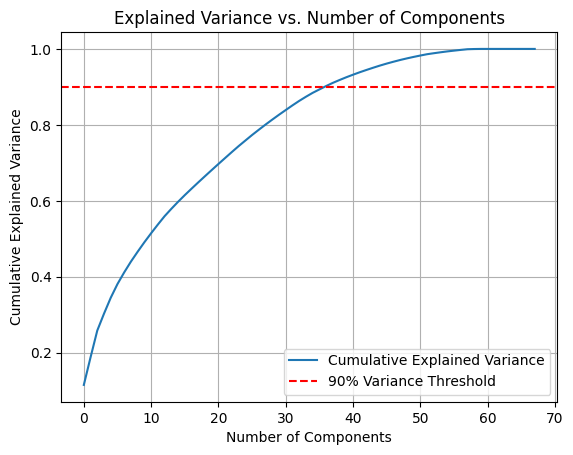

In [494]:
pca = PCA()
pca.fit(scaled_features)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.plot(cumulative_explained_variance, label='Cumulative Explained Variance')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Variance Threshold')

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.legend()
plt.grid(True)
plt.show()

In [495]:
n_comp_90 = np.argmax(cumulative_explained_variance >= 0.9) + 1
n_comp_90

37

In [496]:
n_comp_95 = np.argmax(cumulative_explained_variance >= 0.95) + 1
n_comp_95

44

In [497]:
n_components = 37
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(scaled_features)

pca_columns = [f'PCA_{i+1}' for i in range(n_components)]
df_pca = pd.DataFrame(data=pca_result, columns=pca_columns)
df_pca['f_purchase_lh'] = df8['f_purchase_lh']

In [498]:
df_pca.head()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,...,PCA_29,PCA_30,PCA_31,PCA_32,PCA_33,PCA_34,PCA_35,PCA_36,PCA_37,f_purchase_lh
0,-0.166765,-0.348185,-0.808023,0.312772,1.494825,0.250866,0.620609,0.529243,1.452825,1.549804,...,-0.866450,0.356056,0.087159,-0.427045,-0.015346,-0.197834,0.350540,-0.456607,0.867497,0.0
1,0.670673,-1.141153,-1.474708,0.274941,0.629202,-1.156665,-3.799673,-0.890372,0.702442,1.749778,...,-0.320098,-0.155796,-0.329779,-0.299061,-0.431485,0.379728,0.155645,-0.039282,-0.100213,0.0
2,-0.785353,-1.573642,-0.176831,-0.344946,-0.633755,0.341264,0.596916,-0.208327,0.153556,-0.225040,...,-1.259123,-0.599364,-0.376456,0.292175,-0.407011,0.243559,-0.149361,0.025420,-0.187269,0.0
3,-0.554755,-2.138101,-0.377581,-0.244823,-0.210318,0.407383,1.385522,-0.142289,0.656425,0.423448,...,-0.808085,0.151068,0.093451,-0.171430,-0.319297,0.045610,0.016369,0.049791,0.177755,NaN
4,-0.484266,-1.661170,-0.597114,-0.546553,0.060113,0.304240,1.416627,-0.426336,0.211469,0.160600,...,0.602924,0.227841,0.656095,-0.573103,-0.998896,0.264117,-0.179994,0.617506,-0.741437,0.0


In [499]:
final_df = df_pca

In [500]:
# Train Test Split -> ensure 0:1 ratio is maintained in train and test set 
X = final_df.drop(['f_purchase_lh'], axis=1)
y = final_df['f_purchase_lh']

In [501]:
nan_values = y.isnull().sum()
nan_values

1796

In [502]:
#final_df = final_df.dropna(subset=['f_purchase_lh'])
final_df['f_purchase_lh'] = final_df['f_purchase_lh'].fillna(0)

# Reassign X and y after handling NaN values
X = final_df.drop(['f_purchase_lh'], axis=1)
y = final_df['f_purchase_lh']

# Perform train-test split with stratify=y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [503]:
final_df.shape

(17992, 38)

In [504]:
# from imblearn.over_sampling import SMOTE
# from sklearn.model_selection import train_test_split

# # split with stratify = y to maintain 0:1 ratio 
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)



In [505]:
# # Instantiate SMOTE
# smote = SMOTE(random_state=42)

# # Fit and apply SMOTE only on the training set
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

smote = SMOTE(random_state=42)

# Apply SMOTE to the training data only to avoid data leakage
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [517]:
# from xgboost import XGBClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import classification_report, accuracy_score

# # Initialize XGBoost classifier
# xgb_model = XGBClassifier(random_state=42)

# # Define hyperparameter grid for tuning
# param_grid = {
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'n_estimators': [100, 200, 300],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.8, 0.9, 1.0],
#     'gamma': [0, 1, 2],
#     'min_child_weight': [1, 3, 5],
#     'reg_alpha': [0, 1, 2],
#     'reg_lambda': [0, 1, 2]
# }

# # Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1)

# # Fit the model to the resampled training data
# grid_search.fit(X_train_resampled, y_train_resampled)

# # Get the best hyperparameters
# best_params = grid_search.best_params_

# # Train the XGBoost model with the best hyperparameters on the entire training data
# final_xgb_model = XGBClassifier(**best_params, random_state=42)
# final_xgb_model.fit(X_train_resampled, y_train_resampled)

# # Make predictions on the test set
# y_pred = final_xgb_model.predict(X_test)

# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# classification_report_str = classification_report(y_test, y_pred)

# # Print the best hyperparameters and evaluation metrics
# print("Best Hyperparameters:", best_params)
# print(f"Accuracy with tuned XGBoost model: {accuracy:.4f}")
# print("Classification Report:\n", classification_report_str)


SECTION 3: MODELS 
--- 
1. NN
2. RF
3. XGB
4. LG 
5. Ensemble 

In [506]:
y_train_resampled.value_counts()

f_purchase_lh
0.0    13879
1.0    13879
Name: count, dtype: int64

In [507]:
pip install hyperopt

Note: you may need to restart the kernel to use updated packages.


In [508]:
# I will just try out XGBoost with Tuning here, you can copy & paste your code or modify my part 
import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import accuracy_score

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        #'objective': ['binary:logistic', 'reg:logistic', 'reg:squarederror'],
        'objective':'binary:logistic',
        'seed': 0
    }



In [509]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], objective =space['objective'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train_resampled, y_train_resampled), ( X_train_resampled, y_train_resampled)]
    
    clf.fit(X_train_resampled, y_train_resampled,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }


In [510]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore") 
    
    trials = Trials()

    best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                 
0.594609613781606                                      
SCORE:                                                                           
0.5926646290636288                                                               
SCORE:                                                                           
0.6165601555987774                                                               
SCORE:                                                                            
0.5937760489024729                                                                
SCORE:                                                                            
0.6426785218116143                                                                
SCORE:                                                                            
0.6182272853570436                                                                
SCORE:                                                        

In [511]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.8931221216604793, 'gamma': 1.072726185988866, 'max_depth': 10.0, 'min_child_weight': 0.0, 'reg_alpha': 48.0, 'reg_lambda': 0.6662236748944772}


In [512]:
best_model = xgb.XGBClassifier(colsample_bytree = 0.5919100843580228, gamma= 2.1834345304143383, max_depth=12, 
min_child_weight = 2, reg_alpha = 40, reg_lambda = 0.23997476984859265, n_estimators=180, objective='binary:logistic')
best_model.fit(X_train_resampled,y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5919100843580228, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=2.1834345304143383,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=180, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [513]:
from sklearn.metrics import classification_report
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.86      0.91      3470
         1.0       0.03      0.12      0.05       129

    accuracy                           0.83      3599
   macro avg       0.50      0.49      0.48      3599
weighted avg       0.93      0.83      0.88      3599



## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [514]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform. 
    
All relevant code MUST be included in this function.'''
    result = [] 
    return result

##### Cell to check testing_hidden_data function

In [515]:
# This cell should output a list of predictions.
test_df = pd.read_parquet(filepath)
test_df = test_df.drop(columns=["f_purchase_lh"])
print(testing_hidden_data(test_df))

[]


### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!